1.9 - whats in the notebook
    * calculate tsfeatures & some additional tsforge add ons like CoV, and ADI
    * Plot histograms / KDEs of key diagnostics
        - Trend_strength
        - seasonal_strength
        - entropy
        - ADI/intermittency
    
    Stratify by metadata (department, category)
    
    Metric vs metric scaterplots  (show the diagnostics and the plots - to tie them together)
    
    COMBOS
    trend x adi (when trend lies)
    seasonal strength x adi (when seasonality lies)
    entropy x trend strength
    entop x seasonal strength
    CV2 x ADI



## 1. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from pathlib import Path
from tsforge import load_m5
import tsforge as tsf
import seaborn as sns

# Configuration
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

Notebook agenda 

* Reconfirm the unique_id definition
* Compute tsfeatures + tsforge diagnostics per unique_id
* Highlight the “Lie Detector Six”

In [2]:
# read in data 
weekly_df = pd.read_parquet(
    "/Users/jackrodenberg/Desktop/real-world-forecasting-foundations/output/1_08_output.parquet"
)

In [3]:
weekly_df.head()

,unique_id,ds,y,item_id,store_id,dept_id,cat_id,state_id,wm_yr_wk,month,year,snap_CA,snap_TX,snap_WI,event_name_1,event_name_2,event_name_3,event_type_1,event_type_2,event_type_3
0,FOODS_1_001_CA_1,2011-01-23,3.0,FOODS_1_001,CA_1,FOODS_1,FOODS,CA,11101,1,2011,0,0,0,None,None,None,None,None,None
1,FOODS_1_001_CA_1,2011-01-30,9.0,FOODS_1_001,CA_1,FOODS_1,FOODS,CA,11101,1,2011,1,1,1,None,None,None,None,None,None
2,FOODS_1_001_CA_1,2011-02-06,7.0,FOODS_1_001,CA_1,FOODS_1,FOODS,CA,11102,2,2011,1,1,1,SuperBowl,None,None,Sporting,None,None
3,FOODS_1_001_CA_1,2011-02-13,8.0,FOODS_1_001,CA_1,FOODS_1,FOODS,CA,11103,2,2011,0,1,1,ValentinesDay,None,None,Cultural,None,None
4,FOODS_1_001_CA_1,2011-02-20,14.0,FOODS_1_001,CA_1,FOODS_1,FOODS,CA,11104,2,2011,0,0,0,PresidentsDay,None,None,National,None,None


In [4]:
weekly_df['unique_id'] = weekly_df['unique_id'].astype(str)

In [5]:
from tsforge.eda.ts_features_extension import permutation_entropy,MI_top_k_lags,ADI
from tsfeatures import tsfeatures,lumpiness,stl_features,statistics
# using nixtla's tsfeatures 
id_lvl_feats = tsfeatures(

    ts = weekly_df,
    # frequency of data is weekly, so here we input 52     
    freq=52,

    # COMPUTE LIE detector six 
    features=[
        statistics,
        lumpiness, # variance of variances 
        permutation_entropy, # permutation entropy 
       # MI_top_k_lags, # sum of MI over top 5 lags 
        stl_features, # STL decomposition Features (Trend, Seasonal Strength)
        ADI, # Avg Demand Interval
      #  pacf_features,
        ],

        scale=False # ENSURE YOU TURN THIS OFF for accurate statistics, otherwise outputs are standard scaled for model training.. 
)

 * Plot histograms / KDEs of key diagnostics
        - Trend_strength
        - seasonal_strength
        - entropy
        - ADI/intermittency
    

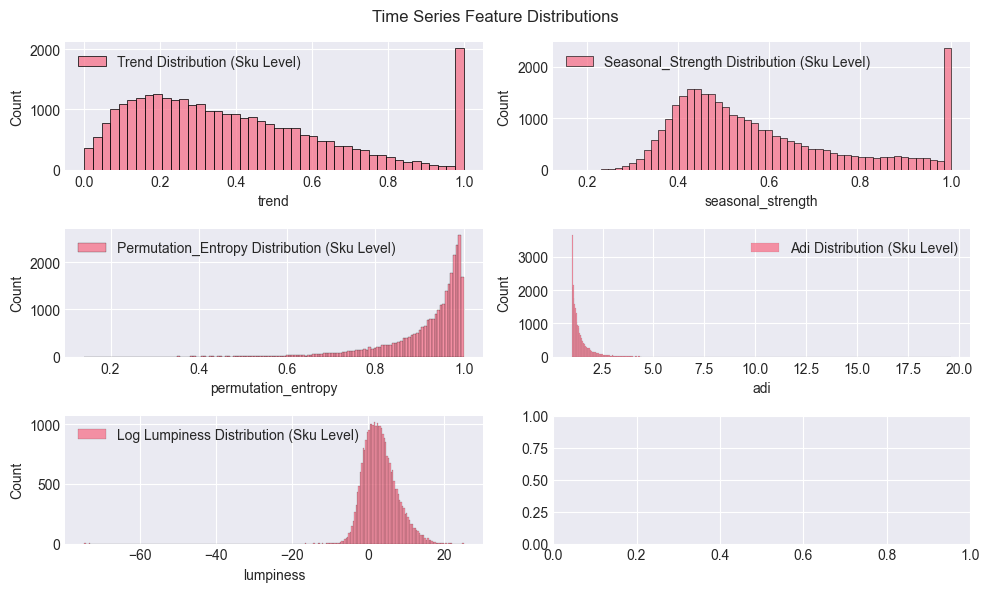

In [6]:
key_inds = ['trend','seasonal_strength','permutation_entropy','adi','lumpiness']

fig, ax = plt.subplots(figsize=(10,6),ncols=2,nrows=3)

ax = ax.flatten()
for ix, ind in enumerate(key_inds):
    if key_inds[ix] == 'lumpiness':
        sns.histplot(id_lvl_feats[ind].pipe(np.log),ax=ax[ix],label=f"Log {ind.title()} Distribution (Sku Level)")
    else:
        sns.histplot(id_lvl_feats[ind],ax=ax[ix],label=f"{ind.title()} Distribution (Sku Level)")
    ax[ix].legend()
    
fig.suptitle("Time Series Feature Distributions")
fig.tight_layout()

In [7]:
# lets aggregate up our hierarchy to get a hierarchical characterizations 

#static df; get static categories to join back to dataset 
static_df = pd.concat(
    [weekly_df[['unique_id']],weekly_df.select_dtypes(include='category')],
axis=1).drop_duplicates('unique_id')

tsfeat_df = id_lvl_feats.merge(
    static_df,
    on=['unique_id']
)

In [48]:
hier_dfs = []
for col in static_df.drop("unique_id",axis=1):

    h_df = (
        tsfeat_df
        # group by the static variable and calculate summary statistics
        .groupby(col)[key_inds]
        .describe()
        .stack()
        .reset_index(names=[col, "stats"])
        .query("stats in ('mean','std','min','max','median')")  # only keep statistics of interest
        .assign(hier_id=col,hier_id_value = lambda df: df[col])  # assign hierarchy id for concatenation..
        .melt(id_vars=[col, "stats", "hier_id","hier_id_value"], var_name="metric", value_name="value")  # melt to long format for concatenation/analysis
    ) 
    hier_dfs.append(h_df) # append to list


hier_metrics = pd.concat(hier_dfs).dropna(axis=1) 

In [81]:
# hier_inspect = hier_metrics.query("stats == 'mean' and hier_id != 'item_id'").groupby(["hier_id"])

# for ix, group in hier_inspect:
#     piv = group.pivot(
#         index='hier_id_value',
#         columns='metric',
#         values='value'
#     )
#     display(piv.style.background_gradient(cmap='Greens'))

In [82]:
hier_inspect = hier_metrics.query("stats == 'mean' and hier_id != 'item_id'").groupby(["hier_id"])

for ix, group in hier_inspect:
    piv = group.pivot(index="hier_id_value", columns="metric", values="value")

    display(
        piv.style.background_gradient(cmap="RdYlGn_r", axis=0)  # color by column, red=high
        .format(precision=3)  # cleaner decimals
        .set_caption(f"{ix[0].upper()} Metrics")  # add title
        .set_table_styles(
            [{"selector": "caption", "props": [("font-size", "16px"), ("font-weight", "bold")]}]
        )
    )


metric,adi,lumpiness,permutation_entropy,seasonal_strength,trend
hier_id_value,,,,,
FOODS,1.339,8607525.858,0.925,0.598,0.445
HOBBIES,1.625,10664.512,0.899,0.559,0.332
HOUSEHOLD,1.520,29243.700,0.908,0.572,0.357


metric,adi,lumpiness,permutation_entropy,seasonal_strength,trend
hier_id_value,,,,,
FOODS_1,1.372,74509.931,0.925,0.539,0.358
FOODS_2,1.408,136369.894,0.911,0.641,0.475
FOODS_3,1.297,14943675.936,0.932,0.592,0.454
HOBBIES_1,1.484,14415.904,0.916,0.542,0.345
HOBBIES_2,2.017,190.827,0.850,0.607,0.297
HOUSEHOLD_1,1.304,55466.229,0.936,0.596,0.430
HOUSEHOLD_2,1.743,2155.572,0.878,0.547,0.283


metric,adi,lumpiness,permutation_entropy,seasonal_strength,trend
hier_id_value,,,,,
CA,1.407,8543519.664,0.921,0.588,0.411
TX,1.472,1284776.610,0.912,0.568,0.377
WI,1.499,886407.033,0.907,0.587,0.388


metric,adi,lumpiness,permutation_entropy,seasonal_strength,trend
hier_id_value,,,,,
CA_1,1.344,1810511.671,0.929,0.572,0.381
CA_2,1.394,134998.968,0.918,0.627,0.486
CA_3,1.324,32187558.268,0.940,0.576,0.424
CA_4,1.564,41009.749,0.899,0.577,0.354
TX_1,1.529,1020776.100,0.906,0.562,0.362
TX_2,1.383,1598098.133,0.924,0.566,0.388
TX_3,1.506,1235455.598,0.906,0.577,0.382
WI_1,1.401,20734.325,0.920,0.586,0.366
WI_2,1.566,476869.763,0.898,0.586,0.375


trend x adi (when trend lies)
seasonal strength x adi (when seasonality lies)
entropy x trend strength
entop x seasonal strength
CV2 x ADI


In [87]:
# create Cov**2 to analyze it along with ADI 

id_lvl_feats = id_lvl_feats.assign(
    cov2 = id_lvl_feats['variance'].pow(.5).truediv(id_lvl_feats['mean']).pow(2)
)

* utilize hex bin plots to visualize the spread and the density of the data.


- Key Tip! 
    - high trend or seasonal strength and high adi would mean that trend strength isn't trustworthy. 

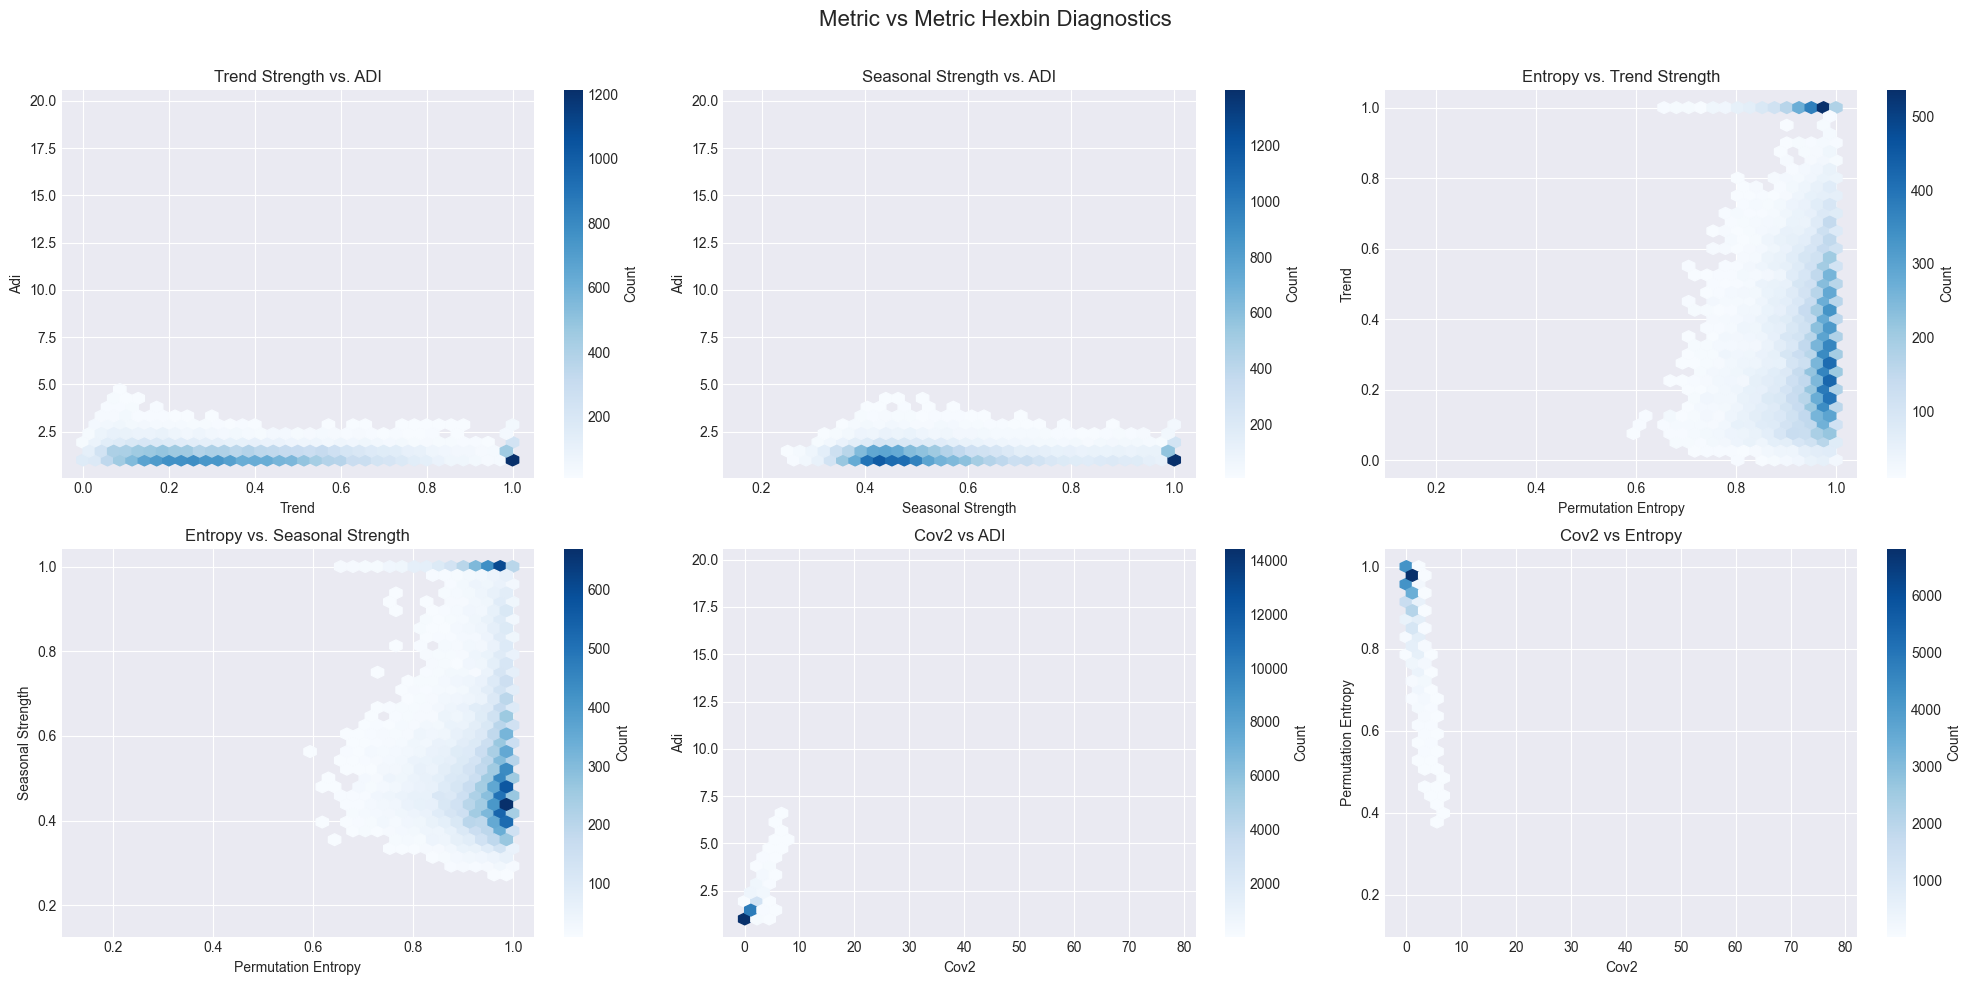

In [30]:
combo_pairs = [
    ("trend", "adi", "Trend Strength vs. ADI"),
    ("seasonal_strength", "adi", "Seasonal Strength vs. ADI"),
    ("permutation_entropy", "trend", "Entropy vs. Trend Strength"),
    ("permutation_entropy", "seasonal_strength", "Entropy vs. Seasonal Strength"),
    ("cov2","adi","Cov2 vs ADI"),
    ("cov2","permutation_entropy","Cov2 vs Entropy")
]

n_cols = 3
n_rows = int(np.ceil(len(combo_pairs) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

for ax, (x_col, y_col, title) in zip(axes, combo_pairs):
    data = id_lvl_feats[[x_col, y_col]].dropna()
    hb = ax.hexbin(
        data[x_col],
        data[y_col],
        gridsize=35,
        cmap="Blues",
        mincnt=10,
    )
    ax.set_title(title)
    ax.set_xlabel(x_col.replace("_", " ").title())
    ax.set_ylabel(y_col.replace("_", " ").title())
    fig.colorbar(hb, ax=ax, label="Count")

# Hide any unused axes
for ax in axes[len(combo_pairs) :]:
    ax.axis("off")

fig.suptitle("Metric vs Metric Hexbin Diagnostics", fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.9)


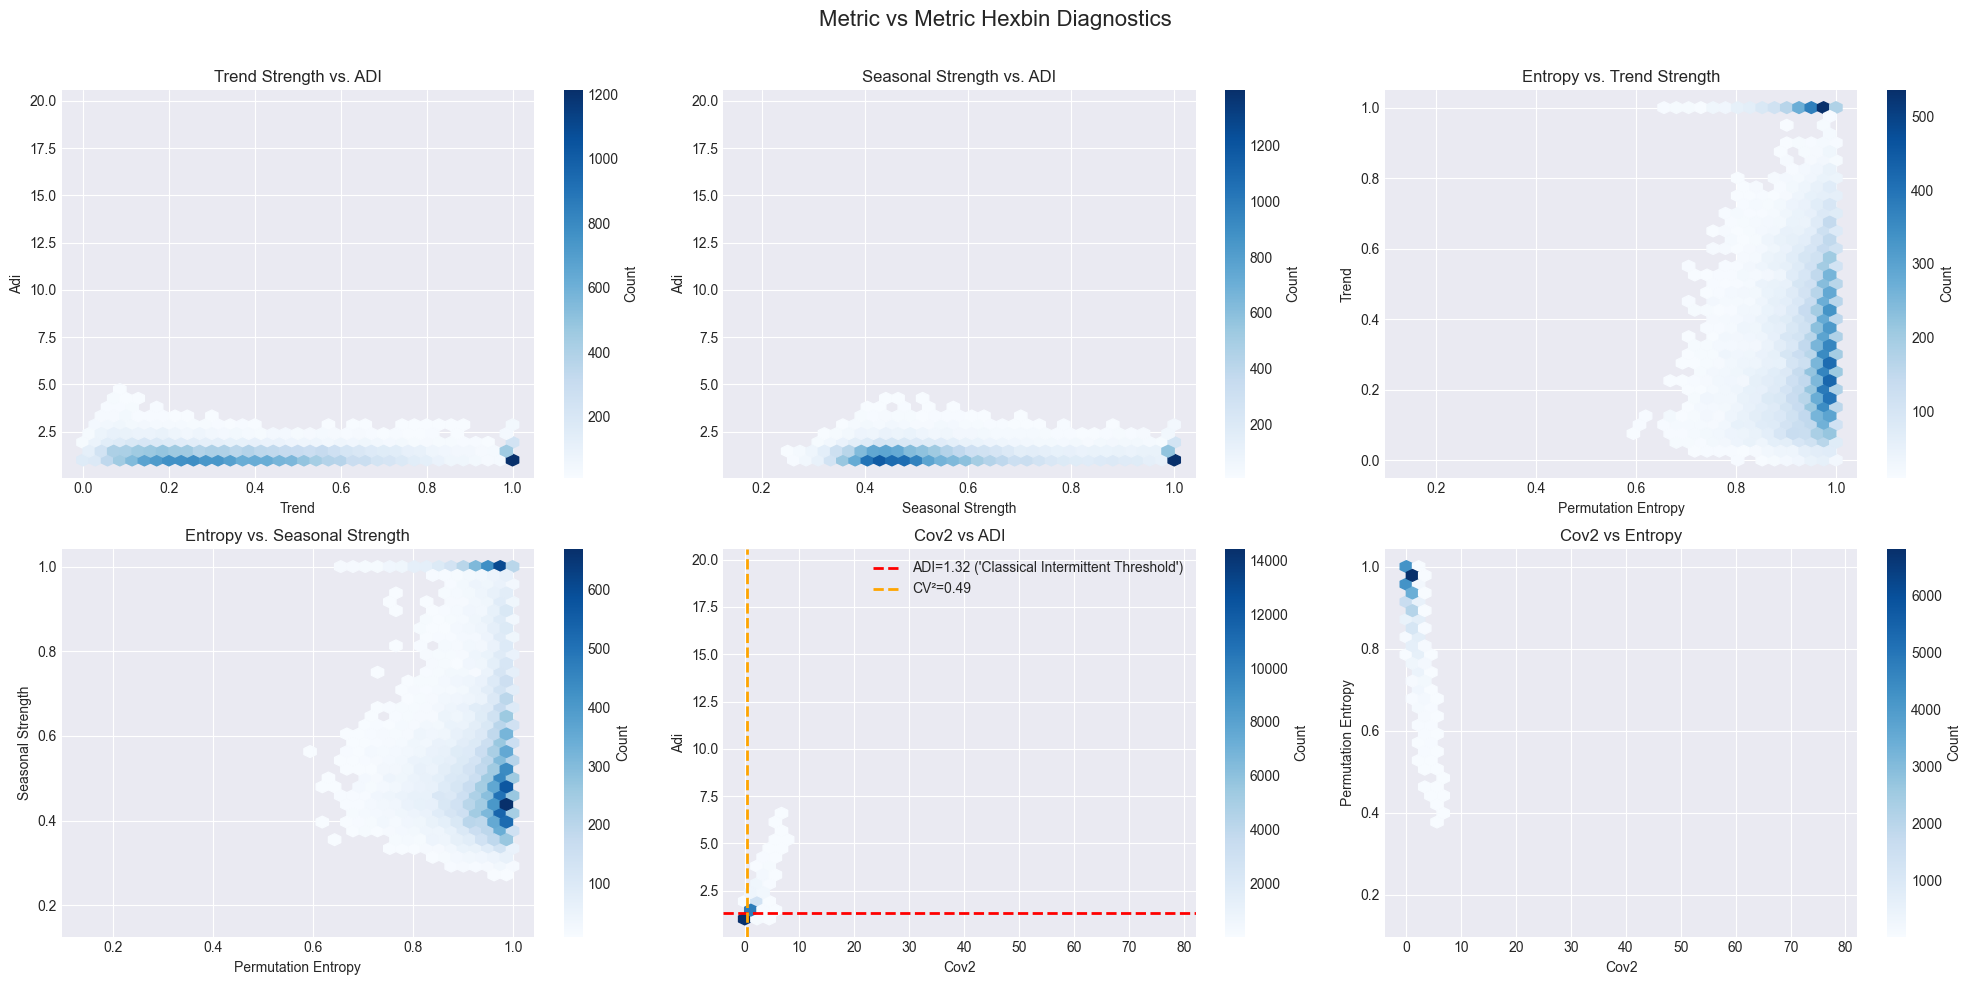

In [91]:
combo_pairs = [
    ("trend", "adi", "Trend Strength vs. ADI"),
    ("seasonal_strength", "adi", "Seasonal Strength vs. ADI"),
    ("permutation_entropy", "trend", "Entropy vs. Trend Strength"),
    ("permutation_entropy", "seasonal_strength", "Entropy vs. Seasonal Strength"),
    ("cov2", "adi", "Cov2 vs ADI"),
    ("cov2", "permutation_entropy", "Cov2 vs Entropy"),
]

n_cols = 3
n_rows = int(np.ceil(len(combo_pairs) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

for ax, (x_col, y_col, title) in zip(axes, combo_pairs):
    data = id_lvl_feats[[x_col, y_col]].dropna()
    hb = ax.hexbin(
        data[x_col],
        data[y_col],
        gridsize=35,
        cmap="Blues",
        mincnt=10,
    )

    # Add intermittent boundary for CV² vs ADI plot
    if x_col == "cov2" and y_col == "adi":
        ax.axhline(
            y=1.32,
            color="red",
            linestyle="--",
            linewidth=2,
            label="ADI=1.32 ('Classical Intermittent Threshold')",
        )
        ax.axvline(
            x=0.49, color="orange", linestyle="--", linewidth=2, label="CV²=0.49"
        )

        # Add text annotations for regions
        xlims = ax.get_xlim()
        ylims = ax.get_ylim()
        # ax.text(
        #     xlims[0] + 0.05 * (xlims[1] - xlims[0]),
        #     1.5,
        #     "Intermittent\n(ADI>1.32)",
        #     fontsize=10,
        #     color="red",
        #     verticalalignment="bottom",
        # )
        # ax.text(
        #     0.6,
        #     ylims[0] + 0.05 * (ylims[1] - ylims[0]),
        #     "Intermittent\n(CV²>0.49)",
        #     fontsize=10,
        #     color="orange",
        #     verticalalignment="bottom",
        # )
        ax.legend(loc="upper right")

    ax.set_title(title)
    ax.set_xlabel(x_col.replace("_", " ").title())
    ax.set_ylabel(y_col.replace("_", " ").title())
    fig.colorbar(hb, ax=ax, label="Count")

# Hide any unused axes
for ax in axes[len(combo_pairs) :]:
    ax.axis("off")

fig.suptitle("Metric vs Metric Hexbin Diagnostics", fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.9)
